In [9]:
import csv
import astropy
import astropy.io.fits as fits
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.table import Table

In [ ]:
def gaussian(wave: np.ndarray, rest_wave, 
                redshift: float, sigma_kms: float, flux: float, geocoronal: bool= False, doublet: bool = False, spacing = None):
        """
        Calculate Gaussian profile in flux units, handling doublets if specified
        
        Args:
            wave: Wavelength array
            rest_wave: Rest wavelength of primary line
            redshift: Redshift
            sigma_kms: Velocity dispersion in km/s
            flux: Flux of primary line
            doublet: Optional DoubletInfo for doublet lines
        """
        # Convert velocity dispersion to wavelength units
        if doublet:
             doublet_wave = rest_wave[1]
             rest_wave = rest_wave[0]

        center = rest_wave * (1 + redshift)

        # print(f'center of line:{center}')
        if geocoronal:
            center = rest_wave
        sigma_wave = rest_wave * sigma_kms / 3e5
        
        # Primary line
        gaussian = (flux / (sigma_wave * np.sqrt(2*np.pi))) * \
                np.exp(-0.5 * ((wave - center) / sigma_wave)**2)
        
        # Add secondary line for doublets
        if doublet:
            rest_wave_2 = doublet_wave
            center_2 = rest_wave_2 * (1 + redshift)
            sigma_wave_2 = rest_wave_2 * sigma_kms / 3e5
            
            flux_2 = flux * 2.95
            gaussian_2 = (flux_2 / (sigma_wave_2 * np.sqrt(2*np.pi))) * \
                        np.exp(-0.5 * ((wave - center_2) / sigma_wave_2)**2)
            gaussian += gaussian_2
        
        return gaussian

In [188]:
def generate_UV_quasar_spectrum(redshift=None, slope = None, intercept = None, spacing = None):
    if redshift == None:
        redshift = np.random.uniform(0.1, 0.17)


    if spacing == None:
        spacing_value = np.random.uniform(0.05, 0.15)
    else:
        spacing_value = spacing
    wavelength = np.arange(1100, 1900, spacing_value)

    if slope == None:
        slope = 1e-16*np.random.uniform(0, 0.5)
        intercept = 1e-16* np.random.uniform(-1, 1)

    count_per_flux = 1e17
    flux_continuum = slope * wavelength + intercept 

    lya_flux =  np.random.uniform(10e-15, 100e-15)
    NV_flux1 =  np.random.uniform(1e-15, 5e-15)
    NV_flux2 =  np.random.uniform(1e-15, 5e-15)
    CIV_flux = np.random.uniform(9e-15, 36e-15)
    OVI_flux = np.random.uniform(1e-15, 20e-15)
    geocoronal_flux = 1000e-15
    gaussian_Lya = gaussian(wavelength, 1215.67, redshift, sigma_kms = 300, flux = lya_flux)
    gaussian_NV = gaussian(wavelength, [1238.82, 1242.80], redshift, sigma_kms = 300, flux = NV_flux1, doublet=True)
    gaussian_NV2 = gaussian(wavelength, [1238.82, 1242.80], redshift+0.001, sigma_kms = 100, flux = NV_flux2, doublet=True)
    gaussian_CIV = gaussian(wavelength, [1548.19, 1550.77], redshift, sigma_kms = 300, flux = CIV_flux, doublet = True)
    gaussian_OVI = gaussian(wavelength, [1031.92, 1037.61], redshift, sigma_kms = 300, flux = OVI_flux, doublet = True)
    gaussian_geocoronal = gaussian(wavelength, 1215.67, redshift, sigma_kms = 300, flux = geocoronal_flux, geocoronal=True)

    all_gaussians = gaussian_Lya + gaussian_NV + gaussian_NV2 + gaussian_CIV + gaussian_OVI + gaussian_geocoronal

    flux_total = flux_continuum + all_gaussians
    flux_err = 0.1 * flux_total
    flux_err[flux_err < 0] = 0.1 * np.abs(flux_err[flux_err < 0])
    flux_err[flux_err == 0] = 1e-15

    print(f'For this spectrum, the redshift is {redshift}')
    print(f'Spacing is {spacing_value}')
    print(f'The slope is {slope}')
    print(f'The intercept is {intercept}')
    print(f'The Lya flux is {lya_flux}')
    print(f'The NV flux is {NV_flux1+NV_flux2}')
    print(f'The CIV flux is {CIV_flux}')
    print(f'The OVI flux is {OVI_flux}')

    counts = flux_total * count_per_flux
    spectable = Table()
    spectable['WAVELENGTH'] = wavelength
    spectable['FLUX'] = flux_total
    spectable['DQ'] = 0
    spectable['DQ'][0] = 55
    spectable['EXPTIME'] = 100
    spectable['ERROR'] = flux_err
    spectable['ERROR_LOWER'] = flux_err - flux_err * 0.01
    spectable['GCOUNTS'] = counts
    spectable['BACKGROUND'] = 0
    spectable['BACKGROUND'][0] = 0
    spectable['NET'] = 0 
    spectable['VARIANCE_FLAT'] = 0

    
    return spectable, slope, intercept, redshift, wavelength, flux_total

In [162]:
table1, m, b, z, wave, flux = generate_UV_quasar_spectrum()

For this spectrum, the redshift is 0.13782937297394166
Spacing is 0.0578514828663825
The slope is 3.5635975988878217e-17
The intercept is 9.793265544084608e-17
The Lya flux is 1.2296790258562682e-14
The NV flux is 6.213753764103112e-15
The CIV flux is 1.959515236341443e-14
The OVI flux is 5.8471878966813764e-15


In [163]:
table2, m, b, z, wave2, flux2 = generate_UV_quasar_spectrum(z, m, b)

For this spectrum, the redshift is 0.13782937297394166
Spacing is 0.08922375393526702
The slope is 3.5635975988878217e-17
The intercept is 9.793265544084608e-17
The Lya flux is 6.513869932373851e-14
The NV flux is 6.6646997853939134e-15
The CIV flux is 1.8966985883604037e-14
The OVI flux is 1.0741107823682617e-14


In [164]:
table3, m, b, z, wave3, flux3 = generate_UV_quasar_spectrum(z, m, b)

For this spectrum, the redshift is 0.13782937297394166
Spacing is 0.100013445577415
The slope is 3.5635975988878217e-17
The intercept is 9.793265544084608e-17
The Lya flux is 9.278837072703519e-14
The NV flux is 5.8113363722361976e-15
The CIV flux is 2.1512007439688463e-14
The OVI flux is 9.145043829342191e-15


In [165]:
table4, m, b, z, wave4, flux4 = generate_UV_quasar_spectrum(z, m, b)

For this spectrum, the redshift is 0.13782937297394166
Spacing is 0.11491044017363457
The slope is 3.5635975988878217e-17
The intercept is 9.793265544084608e-17
The Lya flux is 7.452557678048183e-14
The NV flux is 4.347445207934433e-15
The CIV flux is 2.928670620291629e-14
The OVI flux is 1.0902623236035946e-15


In [187]:
import csv

table1.write('simulated_specs/testspec1.fits', format = 'fits', overwrite = True)
table2.write('simulated_specs/testspec2.fits', format = 'fits', overwrite = True)
table3.write('simulated_specs/testspec3.fits', format = 'fits', overwrite = True)
table4.write('simulated_specs/testspec4.fits', format = 'fits', overwrite = True)


lines = [[z],  # wrap z in a list to make it a row
         ['/Users/eliseke/Research/UV_spectral_fitting/data/simulated_specs/testspec1.fits', 'G140L'],
         ['/Users/eliseke/Research/UV_spectral_fitting/data/simulated_specs/testspec2.fits', 'G140L'],
         ['/Users/eliseke/Research/UV_spectral_fitting/data/simulated_specs/testspec3.fits', 'G140L'],
         ['/Users/eliseke/Research/UV_spectral_fitting/data/simulated_specs/testspec4.fits', 'G140L']]

with open('simulated_specs/testspec1.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',', escapechar=' ', quoting=csv.QUOTE_NONE)
    for line in lines:
        print(line)
        writer.writerow(line)  # <-- write the list directly



[0.13782937297394166]
['/Users/eliseke/Research/UV_spectral_fitting/data/simulated_specs/testspec1.fits', 'G140L']
['/Users/eliseke/Research/UV_spectral_fitting/data/simulated_specs/testspec2.fits', 'G140L']
['/Users/eliseke/Research/UV_spectral_fitting/data/simulated_specs/testspec3.fits', 'G140L']
['/Users/eliseke/Research/UV_spectral_fitting/data/simulated_specs/testspec4.fits', 'G140L']


In [190]:
table5, m, b, z2, wave5, flux5 = generate_UV_quasar_spectrum(spacing = 1.0)

For this spectrum, the redshift is 0.15549691921105155
Spacing is 1.0
The slope is 2.479634094933647e-18
The intercept is 1.8586653144850417e-17
The Lya flux is 2.6422825595414824e-14
The NV flux is 6.157573421308539e-15
The CIV flux is 3.44238417450194e-14
The OVI flux is 7.559262061536354e-15


In [191]:
table5.write('simulated_specs/precoadded_test.fits', format = 'fits', overwrite = True)

In [160]:
def prepare(file):
    """Nicely formats file into columns. Also does bitmasking"""
    
    spec = Table.read(file)

    spec_formatted = Table()

    if spec['DQ'][0] == 55:
        spec['DQ'][0] = 0
        spec_formatted['wave'] = np.array(spec['WAVELENGTH'])
        spec_formatted['flux'] = np.array(spec['FLUX'])
        spec_formatted['flag'] = np.array(spec['DQ'])
        spec_formatted['exp_time'] = np.array(spec['EXPTIME'])

        spec_formatted['error_upper'] = np.array(spec['ERROR'])
        spec_formatted['error_lower'] = np.array(spec['ERROR_LOWER'])
        spec_formatted['G230L_error_up'] = np.zeros_like(spec_formatted['error_lower'])
        spec_formatted['G230L_error_down'] = np.zeros_like(spec_formatted['error_lower'])
        spec_formatted['gcounts'] = np.array(spec['GCOUNTS'])
        spec_formatted['background'] = np.array(spec['BACKGROUND'])
        spec_formatted['net'] = np.array(spec['NET'])
        net_exp_array = np.array(spec['NET'])*spec_formatted['exp_time'] 
        bkg_exp_array = np.array(spec['BACKGROUND'])*spec_formatted['exp_time']
        variance_flat = np.array(spec['VARIANCE_FLAT'])
        spec_formatted['bkg_times_exp'] = np.nan_to_num(bkg_exp_array)
        spec_formatted['net_times_exp_time'] = np.nan_to_num(net_exp_array)
        
        flags = spec_formatted['flag']
        mask = np.where((flags == 0) | (flags == 4))
        masked_spec = spec_formatted[(mask)]
    else:

        spec_formatted['wave'] = np.array(spec['WAVELENGTH'][0])
        spec_formatted['flux'] = np.array(spec['FLUX'][0])
        spec_formatted['flag'] = np.array(spec['DQ'][0])
        
        if (spec['EXPTIME'].shape != (1,)):
            spec_formatted['exp_time'] = np.array(np.max(spec['EXPTIME']))
            
        else: 
            spec_formatted['exp_time'] = np.array(spec['EXPTIME'])
        
        spec_formatted['error_upper'] = np.array(spec['ERROR'][0])
        spec_formatted['error_lower'] = np.array(spec['ERROR_LOWER'][0])
        spec_formatted['G230L_error_up'] = np.zeros_like(spec_formatted['error_lower'])
        spec_formatted['G230L_error_down'] = np.zeros_like(spec_formatted['error_lower'])
        spec_formatted['gcounts'] = np.array(spec['GCOUNTS'][0])
        spec_formatted['background'] = np.array(spec['BACKGROUND'][0])
        spec_formatted['net'] = np.array(spec['NET'][0])
        net_exp_array = np.array(spec['NET'][0])*spec_formatted['exp_time'][0] 
        bkg_exp_array = np.array(spec['BACKGROUND'][0])*spec_formatted['exp_time'][0] 
        variance_flat = np.array(spec['VARIANCE_FLAT'][0])

        spec_formatted['bkg_times_exp'] = np.nan_to_num(bkg_exp_array)
        spec_formatted['net_times_exp_time'] = np.nan_to_num(net_exp_array)
        
        flags = spec_formatted['flag']
        mask = np.where((flags == 0) | (flags == 4))
        masked_spec = spec_formatted[(mask)]
    
    return masked_spec 
    

In [141]:
prepare('/Users/eliseke/Research/UV_spectral_fitting/data/simulated_specs/testspec1.fits')

wave,flux,flag,exp_time,error_upper,error_lower,G230L_error_up,G230L_error_down,gcounts,background,net,bkg_times_exp,net_times_exp_time
float64,float64,int64,int64,float64,float64,float64,float64,float64,int64,int64,int64,int64
1100.0,4.528865587935942e-14,0,100,4.528865587935942e-15,4.4835769320565824e-15,0.0,0.0,4.5288655879359415e-30,0,0,0,0
1100.0944707346239,4.5292544634735816e-14,0,100,4.529254463473582e-15,4.483961918838846e-15,0.0,0.0,4.529254463473581e-30,0,0,0,0
1100.1889414692478,4.5296433390112214e-14,0,100,4.5296433390112214e-15,4.484346905621109e-15,0.0,0.0,4.5296433390112216e-30,0,0,0,0
1100.2834122038716,4.530032214548861e-14,0,100,4.530032214548862e-15,4.484731892403373e-15,0.0,0.0,4.530032214548861e-30,0,0,0,0
1100.3778829384955,4.530421090086501e-14,0,100,4.5304210900865015e-15,4.485116879185636e-15,0.0,0.0,4.530421090086501e-30,0,0,0,0
1100.4723536731194,4.530809965624141e-14,0,100,4.530809965624141e-15,4.4855018659679e-15,0.0,0.0,4.5308099656241405e-30,0,0,0,0
1100.5668244077433,4.531198841161781e-14,0,100,4.531198841161781e-15,4.485886852750163e-15,0.0,0.0,4.531198841161781e-30,0,0,0,0
1100.6612951423672,4.5315877166994205e-14,0,100,4.5315877166994205e-15,4.486271839532426e-15,0.0,0.0,4.5315877166994206e-30,0,0,0,0
1100.755765876991,4.53197659223706e-14,0,100,4.53197659223706e-15,4.4866568263146896e-15,0.0,0.0,4.5319765922370595e-30,0,0,0,0


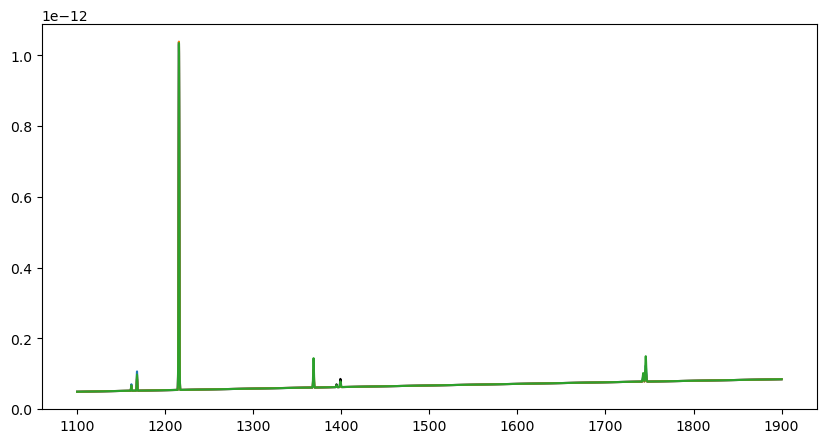

In [68]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(wave, flux, color = 'black')
ax.plot(wave2, flux2)
ax.plot(wave3, flux3)
ax.plot(wave4, flux4)

In [5]:
lines = open('J1000_offnuc_G140L.csv', 'r')
specs = []
for i, line in enumerate(lines):
    if i == 0:
        redshift = float(line)
    else:
        specs.append(line.split(',')[0])

print(redshift,specs)

0.1482 ['/Users/eliseke/Research/UV_spectral_fitting/data/MAST_2025-04-18T18_03_56.559Z/MAST_2025-04-18T18_03_56.559Z/HST/le3i04j9q_x1d.fits', '/Users/eliseke/Research/UV_spectral_fitting/data/MAST_2025-04-18T18_03_56.559Z/MAST_2025-04-18T18_03_56.559Z/HST/le3i04jbq_x1d.fits', '/Users/eliseke/Research/UV_spectral_fitting/data/MAST_2025-04-18T18_03_56.559Z/MAST_2025-04-18T18_03_56.559Z/HST/le3i04jdq_x1d.fits', '/Users/eliseke/Research/UV_spectral_fitting/data/MAST_2025-04-18T18_03_56.559Z/MAST_2025-04-18T18_03_56.559Z/HST/le3i04jfq_x1d.fits', '/Users/eliseke/Research/UV_spectral_fitting/data/MAST_2025-04-18T18_03_56.559Z/MAST_2025-04-18T18_03_56.559Z/HST/le3i04jiq_x1d.fits', '/Users/eliseke/Research/UV_spectral_fitting/data/MAST_2025-04-18T18_03_56.559Z/MAST_2025-04-18T18_03_56.559Z/HST/le3i04jkq_x1d.fits', '/Users/eliseke/Research/UV_spectral_fitting/data/MAST_2025-04-18T18_03_56.559Z/MAST_2025-04-18T18_03_56.559Z/HST/le3i04jmq_x1d.fits', '/Users/eliseke/Research/UV_spectral_fitting/da

In [24]:
fits.reader = fits.open(specs[0])

In [26]:
print(fits.reader[1].header[0])

BINTABLE


In [11]:
table1 = Table.read(specs[0], format='fits' )
table2 = Table.read(specs[1], format = 'fits')
table3 = Table.read(specs[2], format = 'fits')

In [20]:
wave1 = table1['WAVELENGTH'][0]
wave2 = table2['WAVELENGTH'][0]
wave3 = table3['WAVELENGTH'][0]


In [22]:
print(wave1[1] - wave1[0], wave1[2]-wave1[1])
print(wave2[0:10])
print(wave3[0:10])

0.07942707245524616 0.07942713512579758
[1027.50499479 1027.58442187 1027.663849   1027.7432762  1027.82270346
 1027.90213078 1027.98155817 1028.06098562 1028.14041313 1028.2198407 ]
[1027.50473356 1027.58416063 1027.66358777 1027.74301497 1027.82244223
 1027.90186955 1027.98129693 1028.06072438 1028.14015189 1028.21957947]
